In [270]:
using JuMP, GLPKMathProgInterface, Cbc, DataFrames, Plots, StatPlots, Random

## Funções auxiliares

In [271]:
include("../../Functions/dados_e_plot.jl")
include("../../Functions/comparison.jl");

In [272]:
#Valores padrão
G = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 17]
d = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
R = [33, 46, 32, 27, 10, 8, 20, 21, 37, 41, 27, 27]
θ = 0.2
Ns = 10
K = Int.(ones(length(G)))
cg = Int.(zeros(length(G)))

d_array = [[Int(round(d * 0.7)) for d in d]]
for scenario in 2:Ns
    push!(d_array, [Int(round(d * (0.4 + 0.6 * rand()))) for d in d])
end
dsR = hcat(d_array...)

12×10 Array{Int64,2}:
 167  135  112  180  217  188  198  217  127  130
 154  196   90  182  211  189  218  157  119  175
 131  170  169  177  107  160  132  174  144  105
 122   87  127  129  141   91   95   91  170  137
  94   90   78   97   97   99  130   83   62   96
  89   97  118  121  126   93  114  113  107  122
 101  142  143   75  123  123  139   97  100   71
 115   72  152  147  105  140  133  125  146  116
 135  184  139  141  114  175  131   78  124  104
 144  111  194  144  164  121  195  162  111  170
 149  125  187  135  146  193  173  204  153  174
 163   97  139  201  149  191  169  185  177  200

## 1.1 Heurística de solução para o problema de manutenção

Dado um conjunto de capacidades máximas $G_i$ de usinas $i$, a soma das capacidades das usinas que estão operando em um determinado mês é a capacidade disponível desse mês. Cada usina deve entrar em manutenção uma vez por ano. Deve-se distribuir as as paradas de manutenção das usinas durante um ano em uma agenda de manutenção, de modo que a $\textbf{menor das capacidades disponíveis dos meses seja maximizada}$.

A ideia neste caso é distribuir as doze usinas com maiores capacidades nos doze meses. A partir disso, distribuir as usinas restantes, cada uma, no mês que atualmente tem maior capacidade disponível.

In [273]:
function plants_in_a_year(G)
    capacity = sum(G)
    is = collect(range(1, stop = length(G)))
    G = collect(zip(is, G))
    sort!(G, by = G -> G[2], rev = true)
    months = [[month, capacity - G[plant][2], [G[plant][2]], [G[plant][1]]] for (month, plant) in zip(collect(1:12), shuffle(collect(1:12)))]
    G = copy(G[13:end])
    for plant in G
        sort!(months, by = month -> month[2], rev = true)
        push!(months[1][3], plant[2])
        push!(months[1][4], plant[1])
        months[1][2] -= plant[2]
    end
    sort!(months, by = month -> month[1])
    months = DataFrame(month = (month -> month[1]).(months), plants = (month -> month[4]).(months), capacity_available = (month -> month[2]).(months)) #, capacities_used = (month -> month[3]).(months))
    return months
end;

In [274]:
G1 = G
schedule1 = plants_in_a_year(G1)

,month,plants,capacity_available
,Int64,Array…,Int64
1,1,[11],231
2,2,"[1, 9]",228
3,3,[15],231
4,4,[10],228
5,5,[14],235
6,6,[5],225
7,7,"[8, 7]",229
8,8,[6],216
9,9,[3],228


## 1.2 Solução do problema de manutenção com otimização

In [275]:
G2 = G
d2 = d
nplants2 = length(G2)
nmonths2 = length(d2);

In [276]:
m2 = Model(solver = CbcSolver())

@variable(m2, x[1:nplants2, 1:nmonths2], Bin)
@variable(m2, α)

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m2, sum(x[plant, 1:nmonths2]) >= 1)
end

#α deve ser maior do que todas as diferenças entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths2]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m2, α >= sum(G2 .* (1 .- x[1:nplants2, month])) - d2[month])
end

#A demanda sempre deve ser suprida
@constraintref constraints3[1:nmonths2]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m2, sum(G2 .* (1 .- x[1:nplants2, month])) - d2[month] >= 0)
end

@objective(m2, Min, α);

In [277]:
@time solve(m2)
schedule_matrix2 = getvalue(x);

  0.686693 seconds (869.35 k allocations: 43.035 MiB, 3.38% gc time)


In [278]:
dados2, plot1_2, plot2_2 = dados_e_plot(G2, schedule_matrix2, d2, legend = true)
dados2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[9],238.0
2,2,"[4, 9]",220.0
3,3,"[4, 5, 10]",187.0
4,4,"[2, 4, 5, 9, 11]",175.0
5,5,"[1, 4, 6, 7, 8, 11, 15]",135.0
6,6,"[2, 4, 6, 11, 12, 15]",127.0
7,7,"[2, 3, 5, 6, 7, 11]",144.0
8,8,"[8, 9, 11, 12, 13]",165.0
9,9,"[1, 10, 13, 14]",193.0


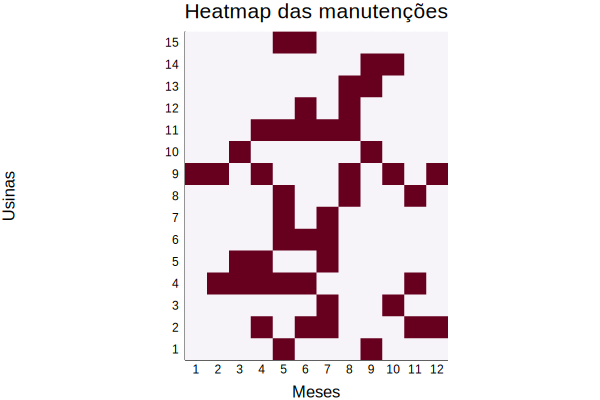

In [279]:
plot1_2

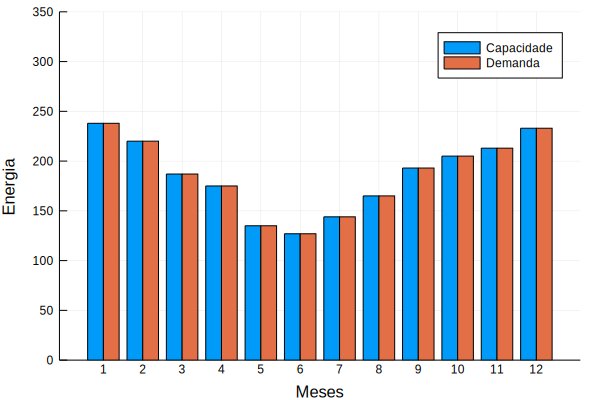

In [280]:
plot2_2

## 1.3 Potência disponível relativa ponderada pela demanda

In [281]:
G3 = G
d3 = d
nplants3 = length(G3)
nmonths3 = length(d3);

In [282]:
m3 = Model(solver = CbcSolver())

@variable(m3, x[1:nplants3, 1:nmonths3], Bin)
@variable(m3, α)

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m3, sum(x[plant, 1:nmonths3]) >= 1)
end

#α deve ser maior do que todas as diferenças relativas entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths3]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m3, α >= (sum(G3 .* (1 .- x[1:nplants3, month])) - d3[month]) / d3[month])
end

#A demanda sempre deve ser suprida
@constraintref constraints3[1:nmonths3]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m3, sum(G3 .* (1 .- x[1:nplants3, month])) - d3[month] >= 0)
end

@objective(m3, Min, α);

In [283]:
@time solve(m3)
schedule_matrix3 = getvalue(x);

  0.229362 seconds (70 allocations: 64.227 KiB)


In [284]:
dados3, plot1_3, plot2_3 = dados_e_plot(G3, schedule_matrix3, d3, legend = true)
dados3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[9],238.0
2,2,"[2, 9, 14]",220.0
3,3,"[4, 5, 10]",187.0
4,4,"[1, 2, 5, 8, 9, 14]",175.0
5,5,"[1, 2, 3, 4, 9, 10, 14, 15]",135.0
6,6,"[4, 6, 7, 9, 10, 11, 15]",127.0
7,7,"[1, 3, 5, 7, 8, 12]",144.0
8,8,"[2, 7, 9, 11, 12, 13]",165.0
9,9,"[1, 8, 10, 14]",193.0


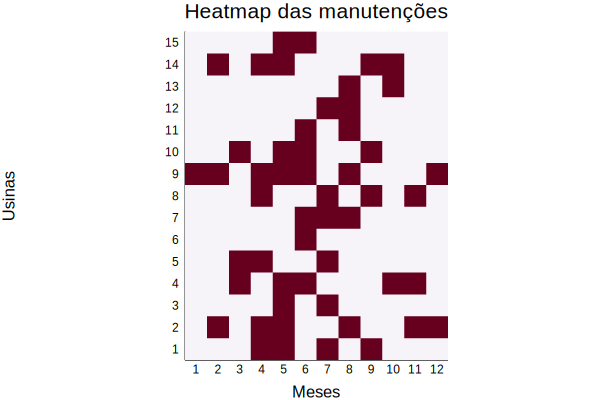

In [285]:
plot1_3

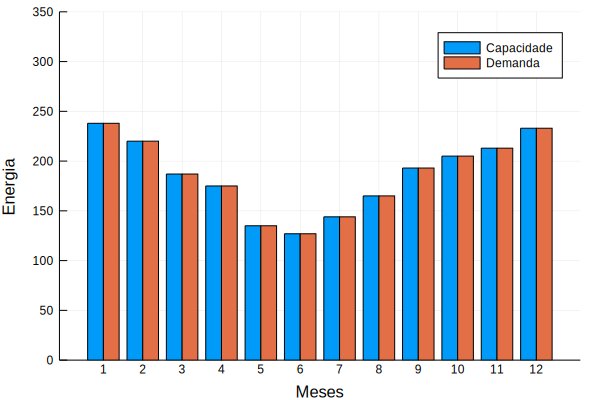

In [286]:
plot2_3

## 1.4 Restrição de potência disponível com margem de 10% da demanda

In [287]:
G4 = G
d4 = d
C4_δ = 5
nplants4 = length(G4)
nmonths4 = length(d4);

In [288]:
m4 = Model(solver = CbcSolver())

@variable(m4, x[1:nplants4, 1:nmonths4], Bin)
@variable(m4, α)
@variable(m4, δ[1:nmonths4])

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m4, sum(x[plant, 1:nmonths4]) >= 1)
end

#α deve ser maior do que todas as diferenças relativas entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths4]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m4, α >= (sum(G4 .* (1 .- x[1:nplants4, month])) - d4[month]) / d4[month])
end

#Agora há uma variável pra que a margem da demanda possa não ser cumprida (com alto custo)
@constraintref constraints3[1:nmonths4]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m4, sum(G4 .* (1 .- x[1:nplants4, month])) + δ[month] >= 1.1 * d4[month])
end

@constraintref constraints4[1:nmonths4]
for month in eachindex(constraints4)
    constraints4[month] = @constraint(m4, 0 <= δ[month] <= 0.1 * d4[month])
end

@objective(m4, Min, α + sum(δ) * C4_δ);

In [289]:
@time solve(m4)
schedule_matrix4 = getvalue(x);

  0.126365 seconds (70 allocations: 66.039 KiB)


In [290]:
dados4, plot1_4, plot2_4 = dados_e_plot(G4, schedule_matrix4, d4, legend = true)
dados4

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],248.0
2,2,[2],243.0
3,3,"[1, 2, 7, 10]",206.0
4,4,"[1, 2, 5, 11]",193.0
5,5,"[1, 2, 3, 4, 7, 8, 9, 11]",149.0
6,6,"[1, 6, 7, 8, 11, 14, 15]",140.0
7,7,"[4, 7, 10, 12, 13]",159.0
8,8,"[3, 5, 9, 14]",182.0
9,9,"[8, 9, 14]",213.0


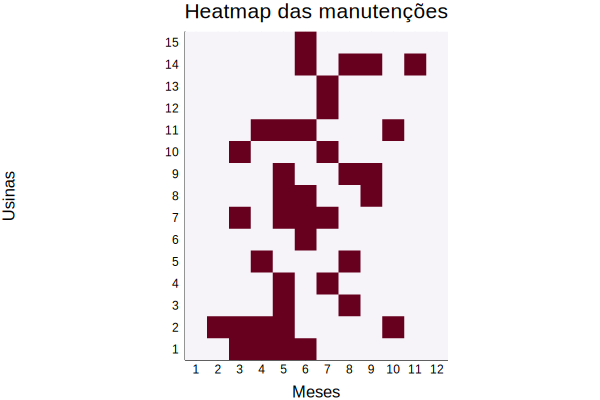

In [291]:
plot1_4

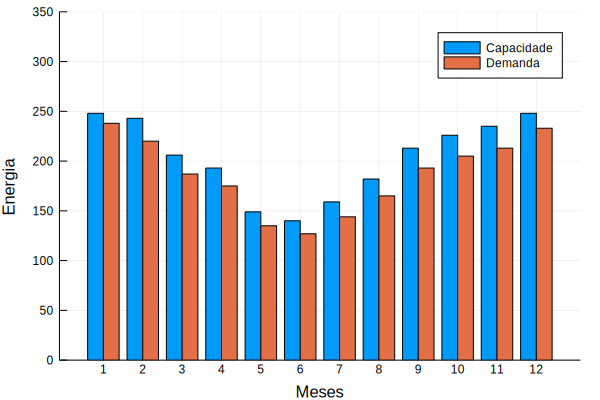

In [292]:
plot2_4

## 1.5 Utilizar cenários de demanda

### Valor esperado na função objetivo

In [293]:
G5 = G
Ns5 = Ns
d5 = dsR
nplants5 = length(G5)
nmonths5 = size(d5)[1];

In [294]:
m5 = Model(solver = CbcSolver())

@variable(m5, x[1:nplants5, 1:nmonths5], Bin)
@variable(m5, α[1:nmonths5, 1:Ns5])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5, sum(x[plant, 1:nmonths5]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints2[month, scenario] = @constraint(m5, sum(G5 .* (1 .- x[1:nplants5, month])) >= d5[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints3[month, scenario] = @constraint(m5, α[month, scenario] >= sum(G5 .* (1 .- x[1:nplants5, month])) - d5[month, scenario])
    end
end

@objective(m5, Min, sum(sum(α[month, scenario] for scenario in 1:Ns5) / Ns5 for month in 1:nmonths5));

In [295]:
@time solve(m5)
schedule_matrix5 = getvalue(x);

  0.098970 seconds (75 allocations: 291.961 KiB)


In [296]:
dados5, plot1_5, plot2_5 = dados_e_plot(G5, schedule_matrix5, d5, legend = true)
dados5

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[7, 8, 13]",217.0
2,2,"[5, 7]",218.0
3,3,"[1, 8, 10, 11, 13]",177.0
4,4,"[2, 4, 5, 6]",170.0
5,5,"[4, 5, 6, 12, 14]",130.0
6,6,"[4, 5, 6, 12, 15]",126.0
7,7,"[1, 2, 4, 5, 6, 11]",143.0
8,8,"[2, 5, 6, 7, 8, 11]",152.0
9,9,"[5, 7, 11, 15]",184.0


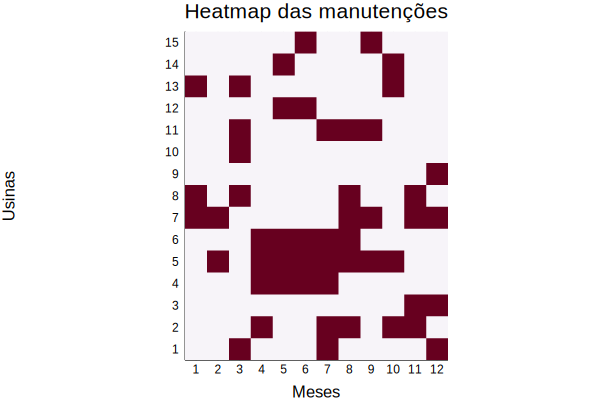

In [297]:
plot1_5

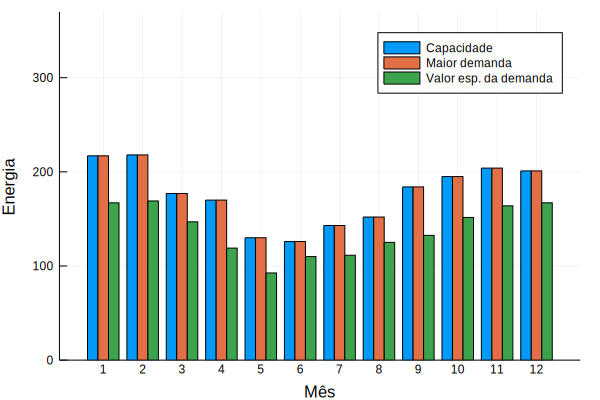

In [298]:
plot2_5

### Valor esperado na restrição

In [299]:
G5_2 = G
d5_2 = dsR

Ns5_2 = Ns
nplants5_2 = length(G5_2)
nmonths5_2 = size(d5_2)[1];

In [300]:
Ed5_2 = [sum(d5_2[month, :]) / Ns5_2 for month in 1:nmonths5_2];

In [301]:
m5_2 = Model(solver = CbcSolver())

@variable(m5_2, x[1:nplants5_2, 1:nmonths5_2], Bin)
@variable(m5_2, α[1:nmonths5_2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5_2, sum(x[plant, 1:nmonths5_2]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5_2, 1:Ns5_2]
for month in 1:nmonths5_2
    for scenario in 1:Ns5_2
        constraints2[month, scenario] = @constraint(m5_2, sum(G5_2 .* (1 .- x[1:nplants5_2, month])) >= d5_2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5_2]
for month in 1:nmonths5_2
    constraints3[month] = @constraint(m5_2, α[month] >= sum(G5_2 .* (1 .- x[1:nplants5_2, month])) - Ed5_2[month])
end

@objective(m5_2, Min, sum(α));

In [302]:
@time solve(m5_2)
schedule_matrix5_2 = getvalue(x);

  0.149420 seconds (75 allocations: 168.992 KiB)


In [303]:
dados5_2, plot1_5_2, plot2_5_2 = dados_e_plot(G5_2, schedule_matrix5_2, d5_2, legend = true)
dados5_2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[7, 8, 13]",217.0
2,2,"[5, 7]",218.0
3,3,"[1, 7, 8, 9, 10, 13]",177.0
4,4,"[1, 8, 9, 11, 13, 15]",170.0
5,5,"[1, 2, 5, 7, 8, 11, 12, 13]",130.0
6,6,"[1, 2, 4, 6, 12, 13, 14]",126.0
7,7,"[1, 3, 4, 5, 8, 9, 13]",143.0
8,8,"[1, 2, 7, 8, 10, 13, 14, 15]",152.0
9,9,"[2, 5, 7, 11, 13]",184.0


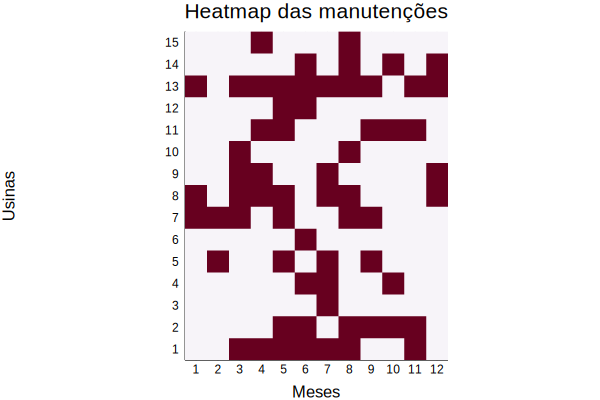

In [304]:
plot1_5_2

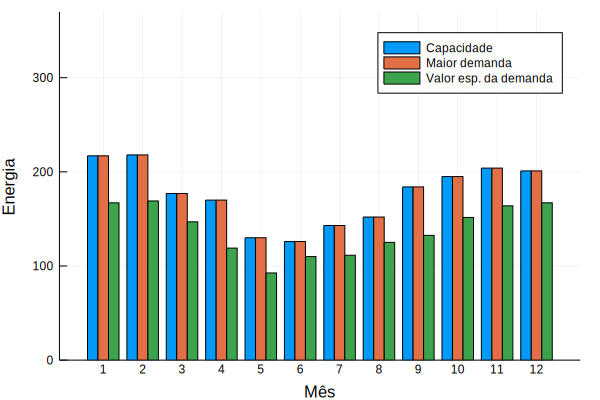

In [305]:
plot2_5_2

### Comparação entre o valor esperado na função objetivo e na restrição

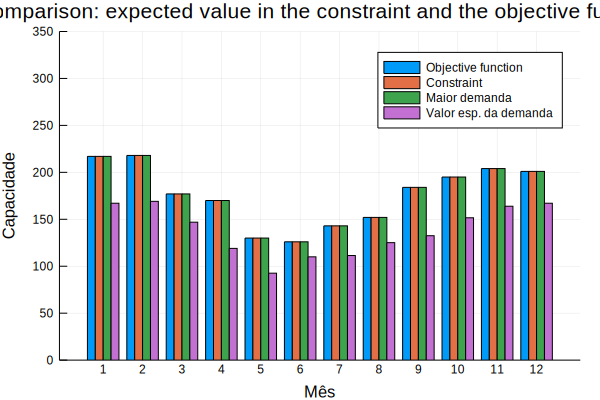

In [306]:
comp5and5_2 = comparison(dsR, G, dados5, schedule_matrix5, dados5_2, schedule_matrix5_2; xlabel1 = "Objective function", xlabel2 = "Constraint", title = "Comparison: expected value in the constraint and the objective function", legend1 = true)
comp5and5_2[1]

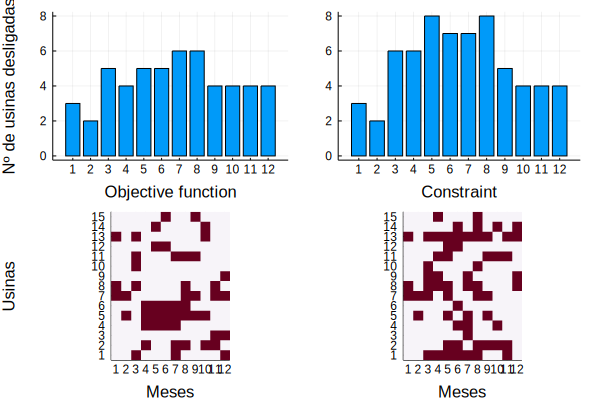

In [307]:
comp5and5_2[2]

## 1.6 Utilizar cenários de renovável e demanda líquida

In [308]:
G6 = G
Ns6 = Ns
d6 = dsR
nplants6 = length(G6)
nmonths6 = size(d6)[1];

In [309]:
m6 = Model(solver = CbcSolver())

@variable(m6, x[1:nplants6, 1:nmonths6], Bin)
@variable(m6, α[1:Ns6])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6, sum(x[plant, 1:nmonths6]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6, 1:Ns6]
for month in 1:nmonths6
    for scenario in 1:Ns6
        constraints2[month, scenario] = @constraint(m6, sum(G6 .* (1 .- x[1:nplants6, month])) >= d6[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6, 1:Ns6]
for month in 1:nmonths6
    for scenario in 1:Ns6
        constraints3[month, scenario] = @constraint(m6, α[scenario] >= sum(G6 .* (1 .- x[1:nplants6, month])) - d6[month, scenario])
    end
end

@objective(m6, Min, sum(α[scenario] for scenario in 1:Ns6) / Ns6);

In [310]:
@time solve(m6)
schedule_matrix6 = getvalue(x);

  0.113114 seconds (75 allocations: 280.180 KiB)


In [311]:
dados6, plot1_6, plot2_6 = dados_e_plot(G6, schedule_matrix6, d6, legend = true)
dados6

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[7, 8, 13]",217.0
2,2,"[4, 13]",218.0
3,3,"[1, 4, 5, 10]",177.0
4,4,"[1, 4, 5, 9, 11]",170.0
5,5,"[1, 2, 4, 7, 8, 9, 11, 13]",157.0
6,6,"[4, 6, 11, 14, 15]",151.0
7,7,"[3, 4, 5, 12, 13]",143.0
8,8,"[5, 9, 11, 13, 14]",173.0
9,9,"[2, 7, 8, 9, 11, 14]",184.0


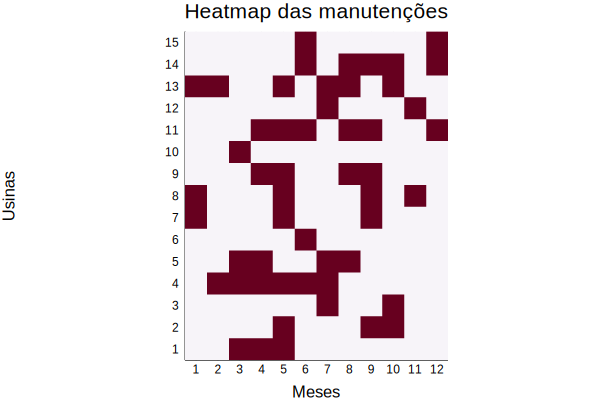

In [312]:
plot1_6

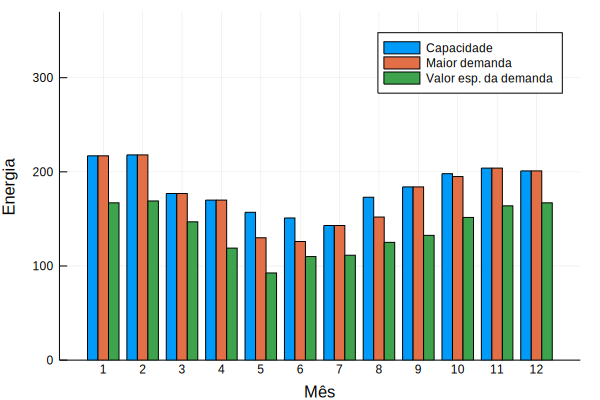

In [313]:
plot2_6

## 1.6.1 CVaR determinístico nas restrições

In [314]:
G6_1 = G
θ6_1 = θ
Ns6_1 = 10
d6_1 = dsR
nCVaR6_1 = Int(floor(θ6_1 * Ns6_1))
nplants6_1 = length(G6_1)
nmonths6_1 = size(d6_1)[1];

In [315]:
CVaR_d6_1 = zeros(nmonths6_1)
for month in 1:nmonths6_1
    CVaR_d6_1[month] = sum(sort(d6_1[month, :])[(Ns6_1 - nCVaR6_1 + 1):Ns6_1]) / nCVaR6_1
end

In [316]:
m6_1 = Model(solver = CbcSolver())

@variable(m6_1, x[1:nplants6_1, 1:nmonths6_1], Bin)
@variable(m6_1, α)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_1]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_1, sum(x[plant, 1:nmonths6_1]) >= 1)
end

#=@constraintref constraints2[1:nmonths6_1]
for month in 1:nmonths6_1
    constraints2[month] = @constraint(m6_1, sum(G6_1 .* (1 .- x[1:nplants6_1, month])) >= CVaR_d6_1[month])
end=#

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_1, 1:Ns6_1]
for month in 1:nmonths6_1
    for scenario in 1:Ns6_1
        constraints2[month, scenario] = @constraint(m6_1, sum(G6_1 .* (1 .- x[1:nplants6_1, month])) >= d6_1[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_1]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m6_1, α >= sum(G6_1 .* (1 .- x[1:nplants6_1, month])) - CVaR_d6_1[month])
end

@objective(m6_1, Min, α);

In [317]:
@time solve(m6_1)
schedule_matrix6_1 = getvalue(x);

  0.022696 seconds (75 allocations: 168.992 KiB)


In [318]:
dados6_1, plot1_6_1, plot2_6_1 = dados_e_plot(G6_1, schedule_matrix6_1, d6_1, CVaR = CVaR_d6_1, legend = true)
dados6_1

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[7, 8]",229.0
2,2,"[1, 9]",228.0
3,3,"[4, 5, 10]",187.0
4,4,"[4, 5, 7, 8, 11]",171.0
5,5,"[1, 2, 6, 7, 8, 9, 11, 13, 14]",130.0
6,6,"[4, 7, 11, 12, 13, 14, 15]",132.0
7,7,"[1, 4, 5, 12, 13]",153.0
8,8,"[5, 11, 12, 14]",163.0
9,9,"[4, 8, 10, 13]",186.0


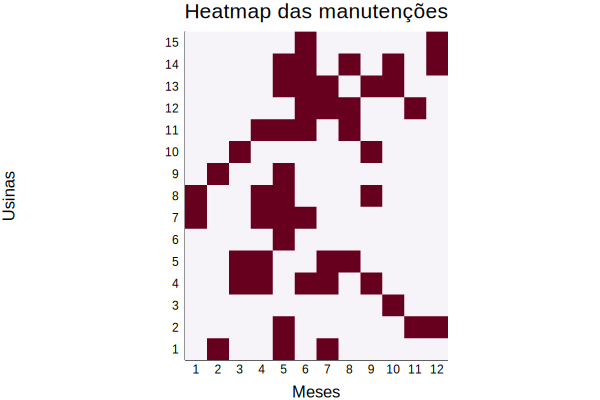

In [319]:
plot1_6_1

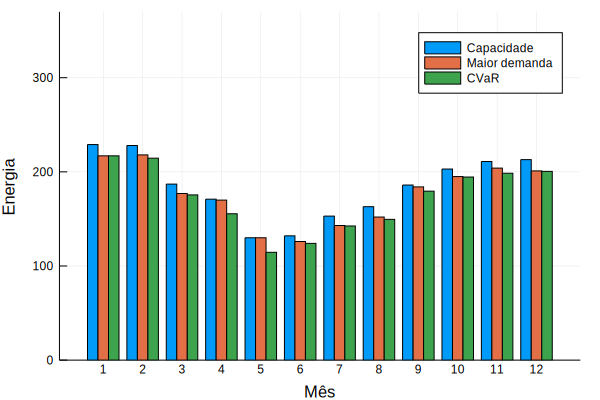

In [320]:
plot2_6_1

## 1.6.2 CVaR como problema de otimização na função objetivo

Um $\alpha$ para cada cenário

In [321]:
G6_2 = G
d6_2 = dsR
θ6_2 = θ

Ns6_2 = Ns
nplants6_2 = length(G6_2)
nmonths6_2 = size(d6_2)[1];

In [322]:
m6_2 = Model(solver = CbcSolver())

@variable(m6_2, x[1:nplants6_2, 1:nmonths6_2], Bin)
@variable(m6_2, α[1:Ns6_2])
@variable(m6_2, z)
@variable(m6_2, δ[1:Ns6_2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_2, sum(x[plant, 1:nmonths6_2]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints2[month, scenario] = @constraint(m6_2, sum(G6_2 .* (1 .- x[1:nplants6_2, month])) >= d6_2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints3[month, scenario] = @constraint(m6_2, α[scenario] >= sum(G6_2 .* (1 .- x[1:nplants6_2, month])) - d6_2[month, scenario])
    end
end

@constraintref constraints4[1:Ns6_2]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m6_2, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns6_2]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m6_2, δ[scenario] <= 0)
end

#@expression(m6_2, C, z - sum(1 / Ns6_2 * δ[scenario] / (1 - θ6_2) for scenario in 1:Ns6_2))

@objective(m6_2, Min, z - sum(1 / Ns6_2 * δ[scenario] / (1 - θ6_2) for scenario in 1:Ns6_2));

In [323]:
@time solve(m6_2)
schedule_matrix6_2 = getvalue(x);

  0.134311 seconds (75 allocations: 285.555 KiB)


In [324]:
dados6_2, plot1_6_2, plot2_6_2 = dados_e_plot(G6_2, schedule_matrix6_2, d6_2, legend = true)
dados6_2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[7, 8, 13]",217.0
2,2,"[9, 10]",218.0
3,3,"[1, 4, 5, 10]",177.0
4,4,"[2, 4, 5, 12]",170.0
5,5,"[1, 2, 4, 7, 8, 9, 11, 13]",157.0
6,6,"[4, 6, 11, 14, 15]",151.0
7,7,"[3, 4, 5, 12, 13]",143.0
8,8,"[5, 9, 11, 13, 14]",173.0
9,9,"[7, 12, 13, 14]",184.0


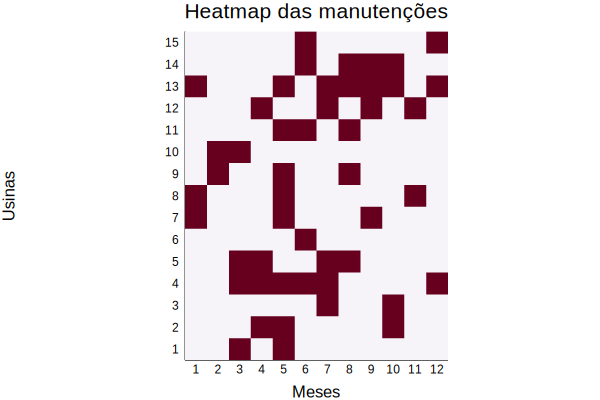

In [325]:
plot1_6_2

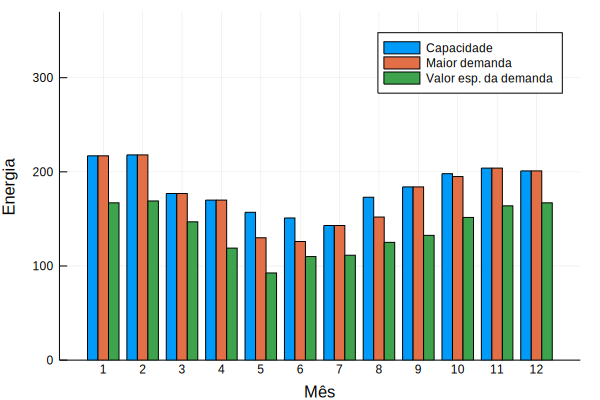

In [326]:
plot2_6_2

## Comparação entre o CVaR na função objetivo e na restrição

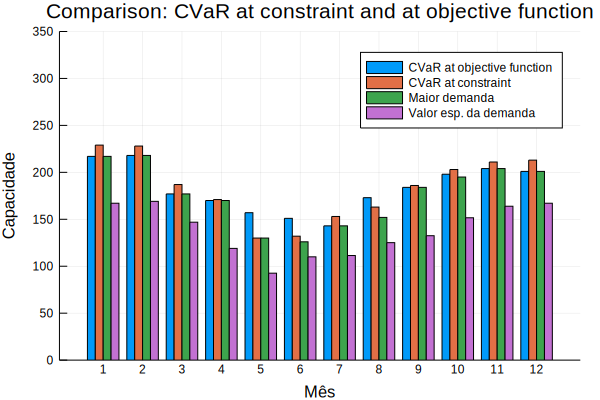

In [327]:
comp6_2and6_1 = comparison(dsR, G, dados6_2, schedule_matrix6_2, dados6_1, schedule_matrix6_1, xlabel2 = "CVaR at constraint", xlabel1 = "CVaR at objective function", title = "Comparison: CVaR at constraint and at objective function", legend1 = true)
comp6_2and6_1[1]

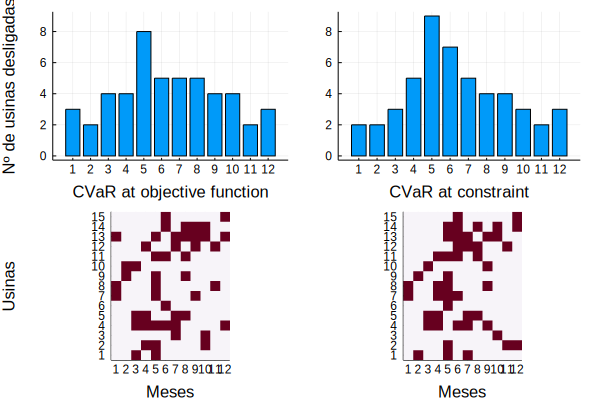

In [328]:
comp6_2and6_1[2]

## Comparação entre o CVaR e o valor esperado

Para fins de comparação, refaço o valor esperado na restrição, porém agora com renovável.

In [329]:
G5_3 = G
d5_3 = dsR

Ns5_3 = Ns
nplants5_3 = length(G5_3)
nmonths5_3 = size(d5_3)[1];

In [330]:
Ed5_3 = [sum(d5_3[month, :]) / Ns5_3 for month in 1:nmonths5_3];

In [331]:
m5_3 = Model(solver = CbcSolver())

@variable(m5_3, x[1:nplants5_3, 1:nmonths5_3], Bin)
@variable(m5_3, α[1:nmonths5_3])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5_3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5_3, sum(x[plant, 1:nmonths5_3]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5_3, 1:Ns5_3]
for month in 1:nmonths5_3
    for scenario in 1:Ns5_3
        constraints2[month, scenario] = @constraint(m5_3, sum(G5_3 .* (1 .- x[1:nplants5_3, month])) >= d5_3[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5_3]
for month in 1:nmonths5_3
    constraints3[month] = @constraint(m5_3, α[month] >= sum(G5_3 .* (1 .- x[1:nplants5_3, month])) - Ed5_3[month])
end

@objective(m5_3, Min, sum(α));

In [332]:
@time solve(m5_3)
schedule_matrix5_3 = getvalue(x);

  0.146277 seconds (75 allocations: 168.992 KiB)


In [333]:
dados5_3, plot1_5_3, plot2_5_3 = dados_e_plot(G5_3, schedule_matrix5_3, d5_3, legend = true)
dados5_3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[7, 8, 13]",217.0
2,2,"[5, 7]",218.0
3,3,"[1, 7, 8, 9, 10, 13]",177.0
4,4,"[1, 8, 9, 11, 13, 15]",170.0
5,5,"[1, 2, 5, 7, 8, 11, 12, 13]",130.0
6,6,"[1, 2, 4, 6, 12, 13, 14]",126.0
7,7,"[1, 3, 4, 5, 8, 9, 13]",143.0
8,8,"[1, 2, 7, 8, 10, 13, 14, 15]",152.0
9,9,"[2, 5, 7, 11, 13]",184.0


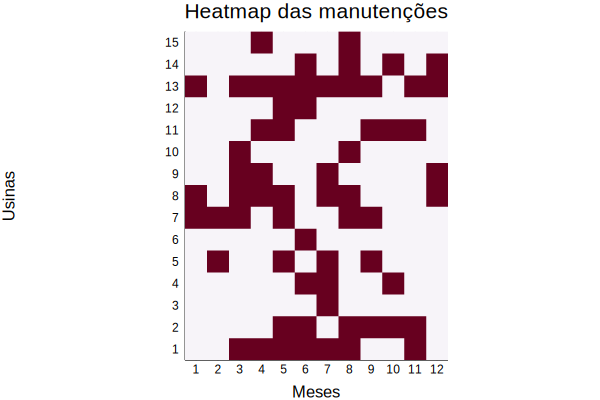

In [334]:
plot1_5_3

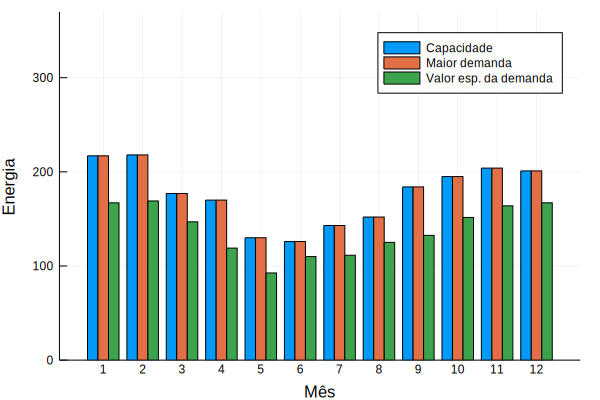

In [335]:
plot2_5_3

Comparação entre o CVaR na restrição e o valor esperado na restrição.

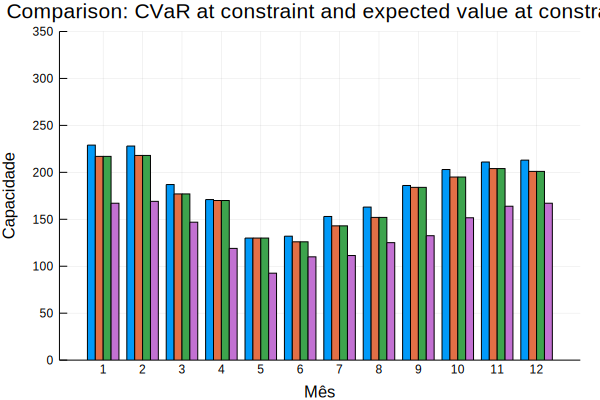

In [336]:
comp6_1and5_3 = comparison(dsR, G, dados6_1, schedule_matrix6_1, dados5_3, schedule_matrix5_3; xlabel1 = "CVaR at constraint", xlabel2 = "Expected value at constraint", title = "Comparison: CVaR at constraint and expected value at constraint")
comp6_1and5_3[1]

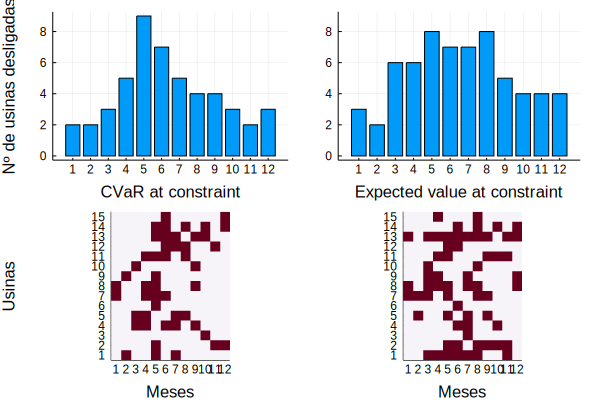

In [337]:
comp6_1and5_3[2]

## 1.6.3 Combinação convexa entre CVaR e valor esperado

In [338]:
G6_3 = G
d6_3 = dsR
θ6_3 = θ
λ6_3 = 0.5

Ns6_3 = Ns
nplants6_3 = length(G6_3)
nmonths6_3 = size(d6_3)[1];

In [339]:
m6_3 = Model(solver = CbcSolver())

@variable(m6_3, x[1:nplants6_3, 1:nmonths6_3], Bin)
@variable(m6_3, α[1:Ns6_3])
@variable(m6_3, z)
@variable(m6_3, δ[1:Ns6_3])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_3, sum(x[plant, 1:nmonths6_3]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_3, 1:Ns6_3]
for month in 1:nmonths6_3
    for scenario in 1:Ns6_3
        constraints2[month, scenario] = @constraint(m6_3, sum(G6_3 .* (1 .- x[1:nplants6_3, month])) >= d6_3[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_3, 1:Ns6_3]
for month in 1:nmonths6_3
    for scenario in 1:Ns6_3
        constraints3[month, scenario] = @constraint(m6_3, α[scenario] >= sum(G6_3 .* (1 .- x[1:nplants6_3, month])) - d6_3[month, scenario])
    end
end

@constraintref constraints4[1:Ns6_3]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m6_3, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns6_3]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m6_3, δ[scenario] <= 0)
end

@expression(m6_3, CVaR, z - sum(1 / Ns6_3 * δ[scenario] / (1 - θ6_3) for scenario in 1:Ns6_3))
@expression(m6_3, Eα, sum(α) / Ns6_3)

@objective(m6_3, Min, λ6_3 * CVaR + (1 - λ6_3) * Eα);

In [340]:
@time solve(m6_3)
schedule_matrix6_3 = getvalue(x);

  0.100723 seconds (75 allocations: 285.555 KiB)


In [341]:
dados6_3, plot1_6_3, plot2_6_3 = dados_e_plot(G6_3, schedule_matrix6_3, d6_3, legend = true)
dados6_3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[7, 8, 13]",217.0
2,2,"[4, 13]",218.0
3,3,"[1, 4, 5, 10]",177.0
4,4,"[4, 5, 7, 9, 10]",170.0
5,5,"[1, 2, 4, 7, 8, 9, 11, 13]",157.0
6,6,"[4, 6, 11, 14, 15]",151.0
7,7,"[3, 4, 5, 12, 13]",143.0
8,8,"[5, 6, 13, 14]",168.0
9,9,"[1, 8, 9, 10, 13]",184.0


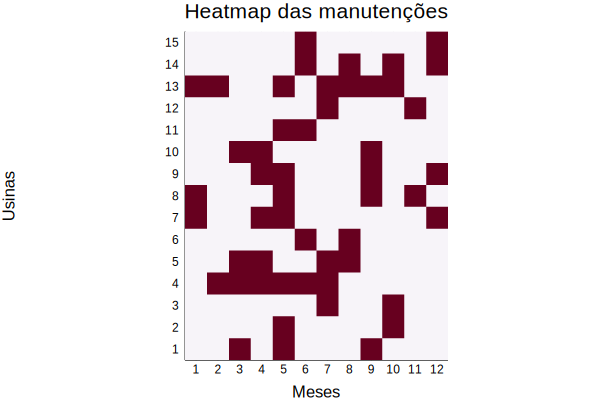

In [342]:
plot1_6_3

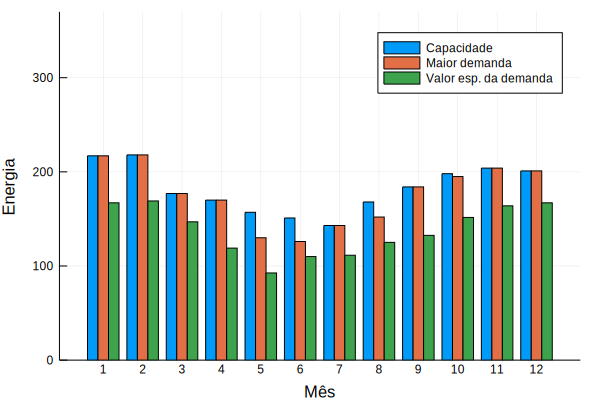

In [343]:
plot2_6_3

## 1.6.4 Custo de manutenção

É adicionado o custo de manutenção na função objetivo. Modelo com cenários de renovável e demanda líquida, um $\alpha$ por mês.

In [344]:
G6_4 = G
Ns6_4 = Ns
d6_4 = dsR
nplants6_4 = length(G6_4)
nmonths6_4 = size(d6_4)[1];

In [345]:
m6_4 = Model(solver = CbcSolver())

@variable(m6_4, x[1:nplants6_4, 1:nmonths6_4], Bin)
@variable(m6_4, α[1:nmonths6_4])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_4, sum(x[plant, 1:nmonths6_4]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_4, 1:Ns6_4]
for month in 1:nmonths6_4
    for scenario in 1:Ns6_4
        constraints2[month, scenario] = @constraint(m6_4, sum(G6_4 .* (1 .- x[1:nplants6_4, month])) >= d6_4[month, scenario])
    end
end

#α maior do que a diferença entre geração e demanda
@constraintref constraints3[1:nmonths6_4, 1:Ns6_4]
for month in 1:nmonths6_4
    for scenario in 1:Ns6_4
        constraints3[month, scenario] = @constraint(m6_4, α[month] >= sum(G6_4 .* (1 .- x[1:nplants6_4, month])) - d6_4[month, scenario])
    end
end

@expression(m6_4, sumK, sum(x))
@expression(m6_4, sumα, sum(α))

@objective(m6_4, Min, sumα + sumK);

In [346]:
@time solve(m6_4)
schedule_matrix6_4 = getvalue(x);

 36.650336 seconds (75 allocations: 280.180 KiB)


In [347]:
dados6_4, plot1_6_4, plot2_6_4 = dados_e_plot(G6_4, schedule_matrix6_4, d6_4, legend = true)
dados6_4

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[4, 14]",217.0
2,2,"[1, 10]",218.0
3,3,"[6, 7, 12]",177.0
4,4,"[5, 9, 12, 14]",170.0
5,5,"[4, 5, 6, 12, 14]",130.0
6,6,"[4, 5, 6, 12, 15]",126.0
7,7,"[4, 5, 6, 12]",143.0
8,8,"[3, 6, 8, 12]",152.0
9,9,"[6, 12]",184.0


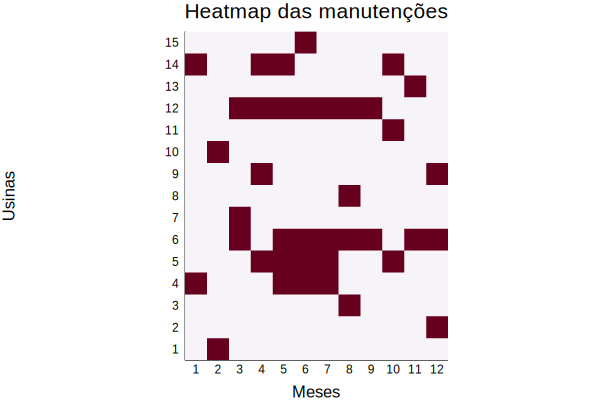

In [348]:
plot1_6_4

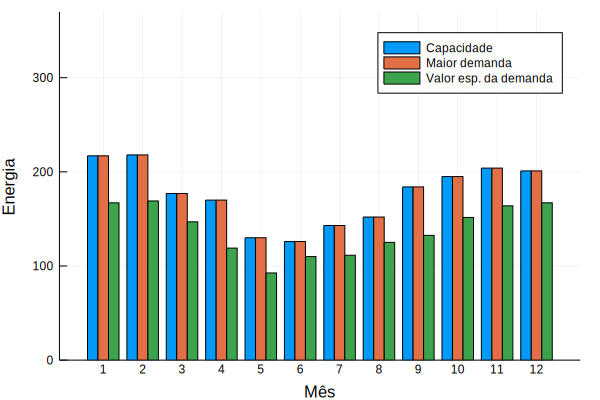

In [349]:
plot2_6_4

## 1.7 Considerando custo de geração e custo de manutenção

É adicionado o custo de geração na função objetivo. Modelo com cenários de renovável e demanda líquida, um $\alpha$ por mês.

In [350]:
G7 = G
Ns7 = Ns
d7 = dsR
cg7 = cg
nplants7 = length(G7)
nmonths7 = size(d7)[1];

In [351]:
m7 = Model(solver = CbcSolver())

@variable(m7, x[1:nplants7, 1:nmonths7], Bin)
@variable(m7, α[1:nmonths7])
@variable(m7, g[1:nplants7, 1:nmonths7] >= 0)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants7]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m7, sum(x[plant, 1:nmonths7]) >= 1)
end

#A geração em cada mês deve superar a demanda em cada mês e cenário
@constraintref constraints2[1:nmonths7, 1:Ns7]
for month in 1:nmonths7
    for scenario in 1:Ns7
        constraints2[month, scenario] = @constraint(m7, sum(g[1:nplants7, month]) >= d7[month, scenario])
    end
end

@constraintref constraints4[1:nmonths7, 1:Ns7]
for month in 1:nmonths7
    for scenario in 1:Ns7
        constraints4[month, scenario] = @constraint(m7, α[month] >= sum(g[1:nplants7, month]) - d7[month, scenario])
    end
end

#Limite da geração
@constraintref constraints3[1:nplants7, 1:nmonths7]
for plant in 1:nplants7
    for month in 1:nmonths7
        constraints3[plant, month] = @constraint(m7, g[plant, month] <= G7[plant] * (1 - x[plant, month]))
    end
end

#=@constraintref constraints4[1:nplants7, 1:nmonths7]
for plant in 1:nplants7
    for month in 1:nmonths7
        constraints4[plant, month] = @constraint(m7, g[plant, month] >= 0)
    end
end=#

@expression(m7, sumK, sum(x))
@expression(m7, sumα, sum(α))
@expression(m7, sumcg, sum(sum(g[1:nplants7, month] .* cg7) for month in 1:nmonths7))

@objective(m7, Min, sumα + sumK + sumcg);

In [352]:
@time solve(m7)
g7 = getvalue(g)
schedule_matrix7 = getvalue(x);

  0.017768 seconds (77 allocations: 327.461 KiB)


In [353]:
dados7, plot1_7, plot2_7 = dados_e_plot(g7, schedule_matrix7, d7, legend = true)
dados7

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],217.0
2,2,[9],218.0
3,3,[10],177.0
4,4,[7],170.0
5,5,[2],130.0
6,6,"[1, 3, 6, 11, 14]",126.0
7,7,"[5, 12]",143.0
8,8,[13],152.0
9,9,[4],184.0


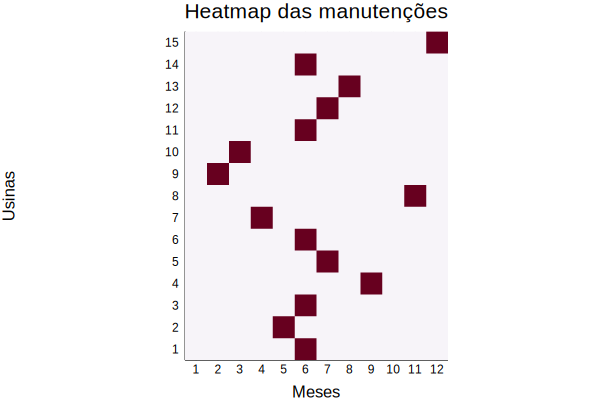

In [354]:
plot1_7

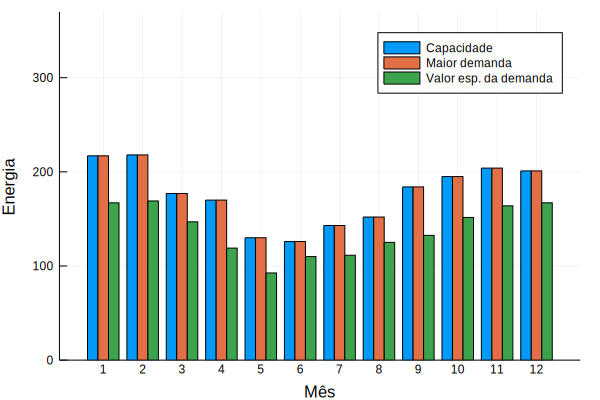

In [355]:
plot2_7

Vamos agora considerar $\alpha$ por mês e cenário.

In [410]:
G7_2 = G
Ns7_2 = Ns
d7_2 = dsR
cg7_2 = cg
nplants7_2 = length(G7_2)
nmonths7_2 = size(d7_2)[1];

In [426]:
m7_2 = Model(solver = CbcSolver())

@variable(m7_2, x[1:nplants7_2, 1:nmonths7_2], Bin)
@variable(m7_2, α[1:nmonths7_2, 1:Ns7_2])
@variable(m7_2, g[1:nplants7_2, 1:nmonths7_2] >= 0)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants7_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m7_2, sum(x[plant, 1:nmonths7_2]) >= 1)
end

#A geração em cada mês deve superar a demanda em cada mês e cenário
@constraintref constraints2[1:nmonths7_2, 1:Ns7_2]
for month in 1:nmonths7_2
    for scenario in 1:Ns7_2
        constraints2[month, scenario] = @constraint(m7_2, sum(g[1:nplants7_2, month]) >= d7_2[month, scenario])
    end
end

@constraintref constraints4[1:nmonths7_2, 1:Ns7_2]
for month in 1:nmonths7_2
    for scenario in 1:Ns7_2
        constraints4[month, scenario] = @constraint(m7_2, α[month, scenario] >= sum(g[1:nplants7_2, month]) - d7_2[month, scenario])
    end
end

#Limite da geração
@constraintref constraints3[1:nplants7_2, 1:nmonths7_2]
for plant in 1:nplants7_2
    for month in 1:nmonths7_2
        constraints3[plant, month] = @constraint(m7_2, g[plant, month] <= G7_2[plant] * (1 - x[plant, month]))
    end
end

#=@constraintref constraints4[1:nplants7_2, 1:nmonths7_2]
for plant in 1:nplants7_2
    for month in 1:nmonths7_2
        constraints4[plant, month] = @constraint(m7_2, g[plant, month] >= 0)
    end
end=#

function e(b)
    sum(α)
end

@expression(m7_2, sumα, sum(α) / Ns7_2)
@expression(m7_2, sumK, sum(x))
@expression(m7_2, sumcg, sum(sum(g[1:nplants7_2, month] .* cg7_2) for month in 1:nmonths7_2))

@objective(m7_2, Min, sumα + sumK + sumcg);

In [427]:
@time solve(m7_2)
g7_2 = getvalue(g)
schedule_matrix7_2 = getvalue(x);

  0.026998 seconds (77 allocations: 338.055 KiB)


In [428]:
dados7_2, plot1_7_2, plot2_7_2 = dados_e_plot(g7_2, schedule_matrix7_2, d7_2, legend = true)
dados7_2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],217.0
2,2,[],218.0
3,3,"[9, 10]",177.0
4,4,"[1, 8]",170.0
5,5,"[2, 11]",130.0
6,6,"[7, 12, 14, 15]",126.0
7,7,"[3, 4, 5]",143.0
8,8,[],152.0
9,9,[13],184.0


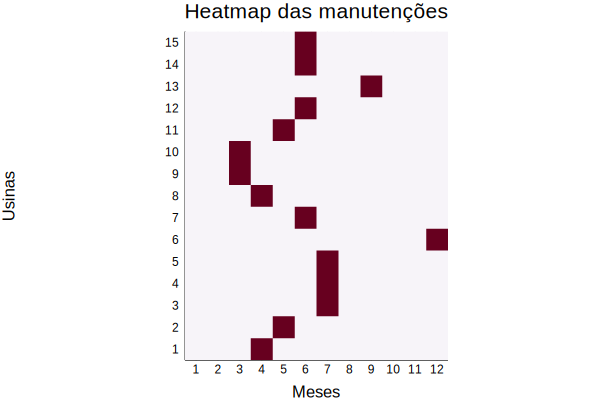

In [429]:
plot1_7_2

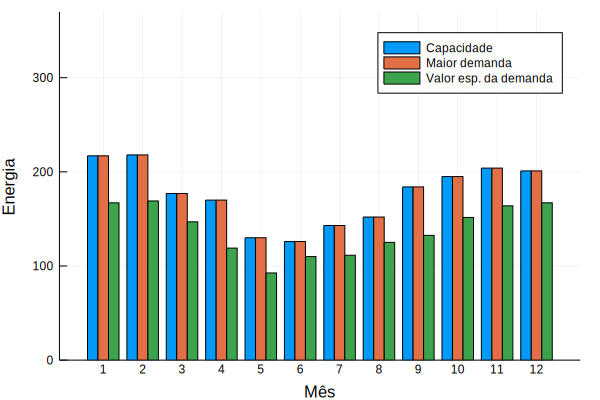

In [430]:
plot2_7_2

## 1.8.1 Probabilidade de falha

Dadas duas variáveis independentes $X$ e $Y$ e suas probabilidades $f_X(x)$ e $f_Y(y)$, respectivamente, como calcular $f_Z(z)$ onde $Z = X + Y$?

Calculamos a probabilidade conjunta $f(x, y) = f_X(x)f_Y(y)$.

Seguimos com $F_Z(z) = P(Z \leq z) = P(X + Y \leq z) = \int\int_{R}f(x, y)dA$, com $R$ definida pela região $X + Y \leq z$. Temos, portanto, a probabilidade acumulada de $X + Y \leq z$.

Temos também $F_Z(z) = \int_{-\infty}^z f_Z(t)dt$. Deriva-se $F_Z(z)$ encontrado e tem-se $f_Z(z)$.

## 1.8.2 Implementação

Pode-se ir além. Segue:

 $F_Z(z) = \int\int_{R}f(x, y)dA = \int_0^z\int_{0}^{z - x}f_X(x)f_Y(y) dx dy = \int_0^zf_X(x)F_Y(z - x)dx$
 
 A isso chama-se convolução:
 
 $\int_0^zf_X(x)F_Y(z - x)dx = (f_X * F_Y)(z)$

Precisamos, agora, considerando as probabilidades de falha dos geradores, calcular a probabilidade (e por que não maximizá-la?) de que a demanda seja suprida.

Cada gerador $i$ tem capacidade disponível $G_i$ e função probabilidade de falha $f_i$. Vamos definir $X_i$ a variável relacionada ao gerador $i$. Se $X = 1$, o gerador funciona; se $X = 0$, ele falha. Portanto, temos a função probabilidade definida da seguinte forma: $f_i = \begin{cases}{p_i, se X_i = 0 \\ 1 - p_i, se X_i = 1}\end{cases}$, com $0 \leq p_i \leq 1$.

Queremos $P(\sum_i G_i X_i \geq D) = P(Z \geq D)$, sendo $D$ a demanda.

$P(Z \geq D) = 1 - P(Z < D) = 1 - F_Z(D)$

Podemos calcular $F_Z(D)$ calculando $\prod_i f_i(x_i)$, $x_i \in \{0, 1\}$ para todas as configurações possíveis de $x_1, x_2, \ldots x_n$ e somando os valores em que $Z \leq D$.

In [431]:
p = [rand() for i in 1:length(G)]
D = 15;

Para duas usinas:

In [432]:
F_Z = 0
for X in [0, 1]
    for Y in [0, 1]
        Z = G[1] * X + G[2] * Y
        if Z < D
            F_Z += (X + (-1)^X * p[1]) * (Y + (-1)^Y * p[2])
        end
    end
end
@show 1 - F_Z;

1 - F_Z = 0.5827990149186458


Para n usinas:

In [433]:
function prob(G, p, D; i = 1, X = [], F_Z = 0)
    for x in [0, 1]
        if i <= length(G) #Se estou até na última usina
            Y = copy(X)
            push!(Y, x)
            F_Z = prob(G, p, D, i = i + 1, X = Y, F_Z = F_Z)
        else #Se passei
            Z = sum(G .* X)
            if Z < D
                A = X + (-1).^X .* p
                prod = 1
                for j in 1:length(X)
                    prod *= A[j]
                end
                F_Z += prod       
            end
            return F_Z
        end
    end
    return F_Z
end;

In [476]:
sum(G)

248

In [480]:
F_Z = prob(G, p, 800)
@show 1 - F_Z;

1 - F_Z = -2.220446049250313e-15


In [469]:
function model_prob(G, p, D, x; i = 1, X = [], F_Z = 0)
    for y in [0, 1]
        if i <= length(G) #Se estou até na última usina
            Y = copy(X)
            push!(Y, y)
            F_Z = model_prob(G, p, D, x, i = i + 1, X = Y, F_Z = F_Z)
        else #Se passei
            Z = sum(G .* X .* (1 .- x))
            if Z < D
                A = X + (-1).^X .* p
                prod = 1
                for j in 1:length(X)
                    prod *= A[j]
                end
                F_Z += prod       
            end
            return F_Z
        end
    end
    return F_Z
end;

In [470]:
function sum_of_prob(G, p, d, x)
    println(x)
    sumF_Z = 0
    for month in 1:length(d)
        sumF_Z += model_prob(G, p, Int(d[month]), x[:, month])
    end
    return sumF_Z
end;